In [60]:
from transformers import AutoImageProcessor, AutoModel
import torch
import torch.nn.functional as F
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
model_name = "facebook/dinov3-vith16plus-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(
    model_name, 
    device_map="auto", 
)

In [3]:
image_path = "datasets/juice_bottle/juice_bottle/train/good/000.png"
image = Image.open(image_path).convert("RGB")

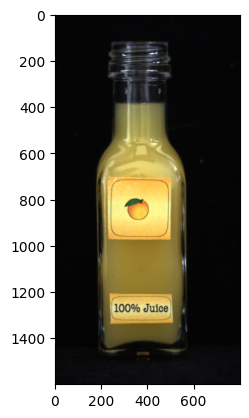

In [4]:
plt.imshow(image)

In [9]:
inputs = processor(images=image, return_tensors="pt").to(model.device)
with torch.inference_mode():
    outputs = model(**inputs, output_hidden_states=True)

In [159]:
len(outputs.hidden_states)  # 33 layers (embedding + 32 transformer layers)

feature_list = [8,16,24,32]
selected_feats = [outputs.hidden_states[i][:,5:,:] for i in feature_list]  # exclude 1 CLS token, 4 register tokens
selected_feats[0].shape

torch.Size([1, 196, 1280])

In [160]:
g = F.normalize(outputs.pooler_output, dim=-1)
g.shape

torch.Size([1, 1280])

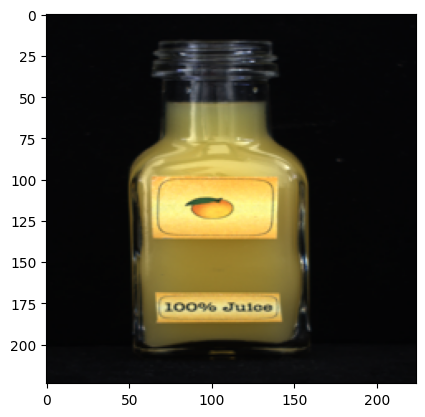

In [207]:
SIZE = (224, 224)
base = image.convert("RGBA").resize(SIZE)
plt.imshow(base)

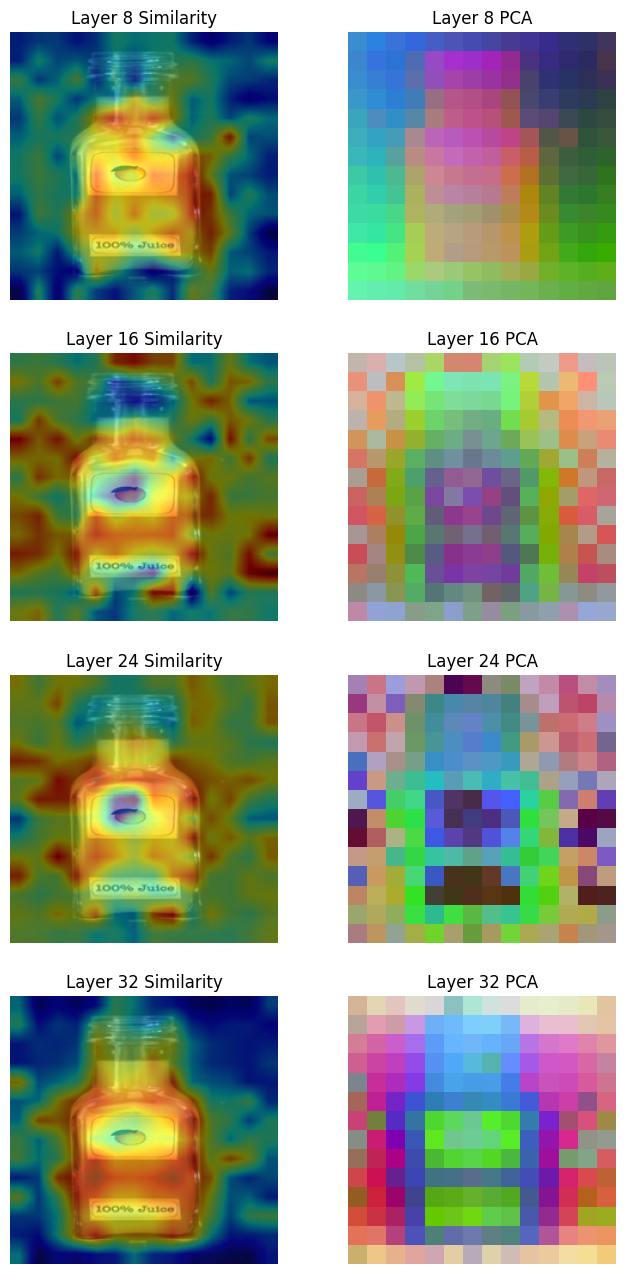

In [211]:
fig, axes = plt.subplots(4, 2, figsize=(8, 16))
for i, feature in enumerate(selected_feats):
    x = F.normalize(feature, dim=-1)
    B, N, C = x.shape
    grid = x.view(B, 14, 14, C).permute(0, 3, 1, 2).contiguous().squeeze(0)
    C, H, W = grid.shape
    patches = grid.permute(1, 2, 0).reshape(-1, C)

    # Compute similarity
    sim = (patches @ g.T).view(H, W)  # (196, 1) -> (14, 14)
    sim = (sim - sim.min()) / (sim.max() - sim.min() + 1e-8)
    sim_map_up = F.interpolate(
        sim.unsqueeze(0).unsqueeze(0), 
        size=SIZE,
        mode='bilinear', 
        align_corners=False
    ).squeeze().cpu().numpy()

    cm = plt.get_cmap('jet')
    colored = (cm(sim_map_up) * 255).astype(np.uint8)
    color_img = Image.fromarray(colored).convert("RGBA")

    arr = np.array(color_img)
    alpha = 0.45
    arr[..., 3] = (alpha * 255)
    overlay = Image.alpha_composite(base, Image.fromarray(arr))
    axes[i, 0].imshow(overlay)
    axes[i, 0].set_title(f"Layer {feature_list[i]} Similarity")
    axes[i, 0].axis('off')

    X = patches - patches.mean(0, keepdim=True)
    U, S, V = torch.pca_lowrank(X, q=3)      # (196,3)
    pca3 = patches @ V[:, :3] / (S[:3]+ 1e-8)
    pca3 = (pca3 - pca3.min()) / (pca3.max() - pca3.min() + 1e-8)
    rgb = (pca3.view(H, W, 3).cpu().numpy() * 255).astype(np.uint8)

    axes[i, 1].imshow(Image.fromarray(rgb))
    axes[i, 1].set_title(f"Layer {feature_list[i]} PCA")
    axes[i, 1].axis('off')